# En este Notebook realizaremos detección, censura y remoción de atípicos utilizando los métodos de RIQ, media-desviación estándar, cuantiles y LOF.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerPathCollection
from sklearn.neighbors import LocalOutlierFactor

import sys
sys.path.append('../../../src/')
import diagnostic_functions

In [2]:
# Cargando datos Boston House
boston_dataset = pd.read_csv('../../../Datasets/Datasets_mod2_1/boston.csv')

In [3]:
# Creamos un dataframe con variables independientes. Usaremos solo 3 variables para propósitos de demostración
#boston = boston_dataset.filter(['RM', 'LSTAT', 'CRIM'], axis=1)
boston = boston_dataset[['RM', 'LSTAT', 'CRIM']].copy()

boston.head()

,RM,LSTAT,CRIM
0,6.575,4.98,0.00632
1,6.421,9.14,0.02731
2,7.185,4.03,0.02729
3,6.998,2.94,0.03237
4,7.147,5.33,0.06905


### Visualización

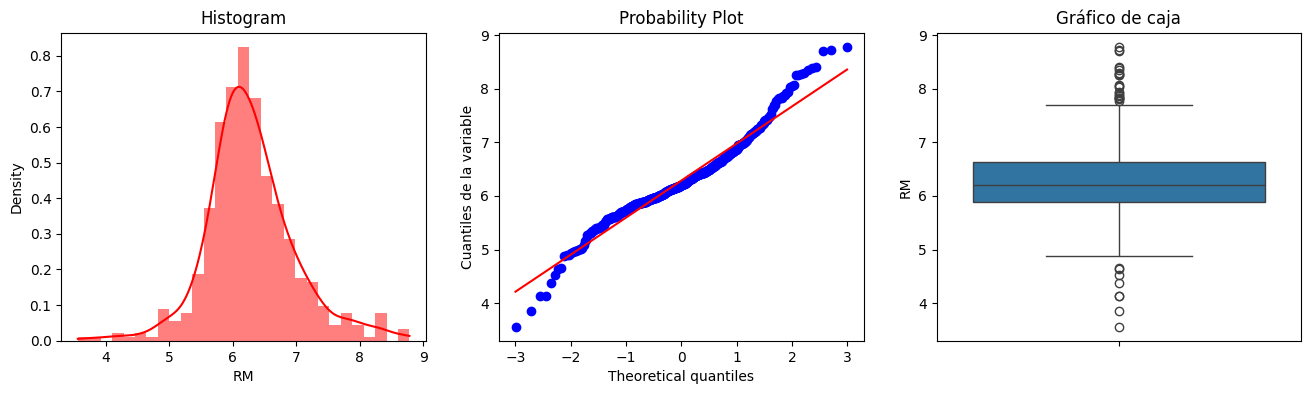

In [4]:
# Visualizamos con la función de diagnóstico los valores extremos en RM
diagnostic_functions.diagnostic_plots2(boston, 'RM')


In [5]:


def find_boundaries_RIQ(df, variable, distance):

    # Calculamos las froteras (distribución sesgada)
    # La distancia es pasada como argunmento

    IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)

    lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
    upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

    return upper_boundary, lower_boundary



def find_boundaries_zscore(df, variable, distance):
    lower_boundary = df[variable].mean() - (df[variable].std() * distance)
    upper_boundary = df[variable].mean() + (df[variable].std() * distance)
    return upper_boundary, lower_boundary

def find_boundaries_quantile(df, variable):
    lower_boundary = df[variable].quantile(0.05)
    upper_boundary = df[variable].quantile(0.95)
    return upper_boundary, lower_boundary

In [6]:
# Encontremos los límites RM usando la regla RIQ
RM_upper_limit, RM_lower_limit = find_boundaries_RIQ(boston, 'RM',1.5)
RM_upper_limit, RM_lower_limit

(7.730500000000001, 4.778499999999999)

### Censura de valores atípicos

In [7]:
# Censuremos los outliers por los limites máximo y mínimo

boston['RM_censured']= np.where(boston['RM'] > RM_upper_limit, RM_upper_limit,
                       np.where(boston['RM'] < RM_lower_limit, RM_lower_limit, boston['RM']))

boston.head(10)

,RM,LSTAT,CRIM,RM_censured
0,6.575,4.98,0.00632,6.575
1,6.421,9.14,0.02731,6.421
2,7.185,4.03,0.02729,7.185
3,6.998,2.94,0.03237,6.998
4,7.147,5.33,0.06905,7.147
5,6.430,5.21,0.02985,6.430
6,6.012,12.43,0.08829,6.012
7,6.172,19.15,0.14455,6.172
8,5.631,29.93,0.21124,5.631
9,6.004,17.10,0.17004,6.004


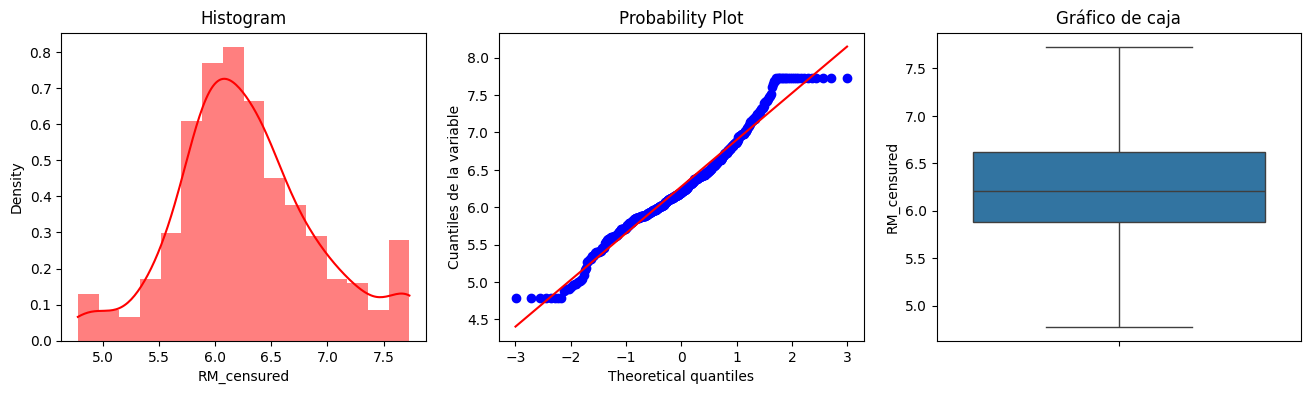

In [8]:
diagnostic_functions.diagnostic_plots2(boston,'RM_censured')

### Remoción de valores atípicos

In [9]:
# Marquemos los outliers en el cto. de datos

outliers_RM = np.where(boston['RM'] > RM_upper_limit, True,
                       np.where(boston['RM'] < RM_lower_limit, True, False))
outliers_RM

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False,

In [10]:
# Removemos del conjunto de datos solo los outliers en RM

boston_trimmed = boston.loc[~outliers_RM ]
boston.shape, boston_trimmed.shape

((506, 4), (476, 4))

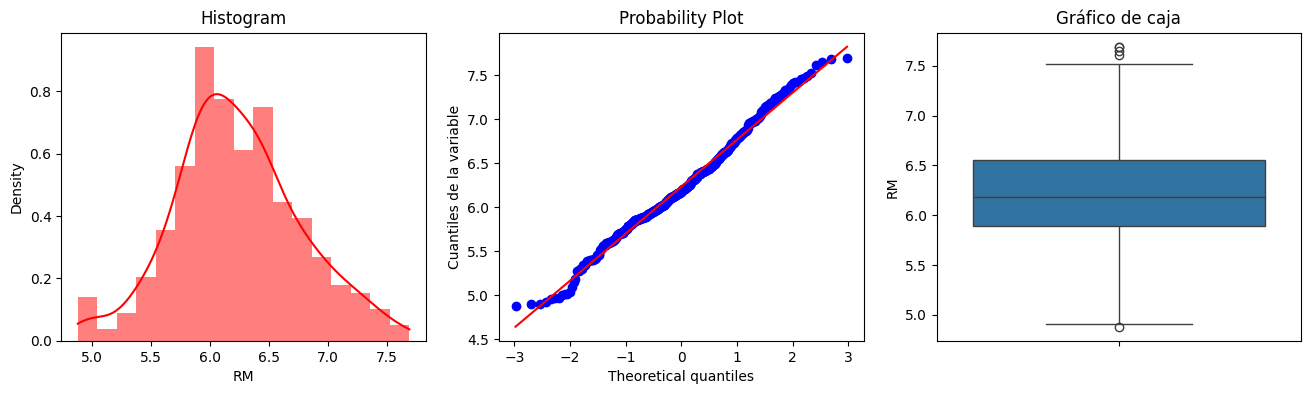

In [11]:
# Exploremos los valores extremos en los datos removidos
# para la variable RM vemos muchos menos outliers 
# que en los datos originales
diagnostic_functions.diagnostic_plots2(boston_trimmed, 'RM')

### Detección y remociuón de atípicos utilizando LOF

In [12]:
np.random.seed(42)

# Generamos los datos sintéticos (inliers) de entrenamiento para propositos de demostración
X_inliers = 0.3 * np.random.randn(100, 2)
X_inliers = np.r_[X_inliers + 2, X_inliers - 2]

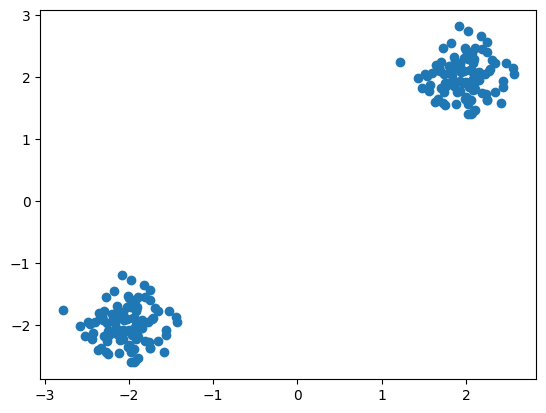

In [13]:
# Graficamos los inliers
X_inliers.shape
plt.scatter(X_inliers[:,0],X_inliers[:,1])
plt.show()

In [14]:
# Generemos algunos outliers (20)
X_outliers = np.random.uniform(low=-4, high=4, size=(20, 2))
X = np.r_[X_inliers, X_outliers]

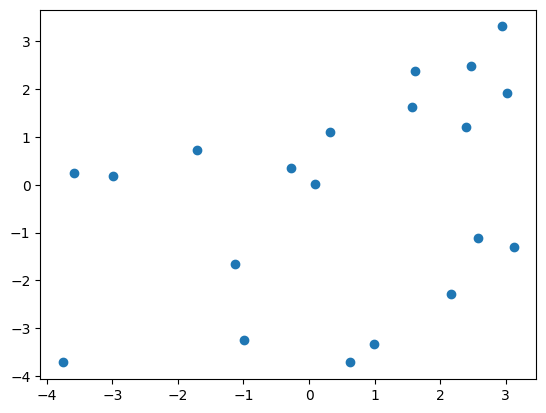

In [15]:
# Graficamos los outliers generados
X_outliers.shape
plt.scatter(X_outliers[:,0],X_outliers[:,1])
plt.show()

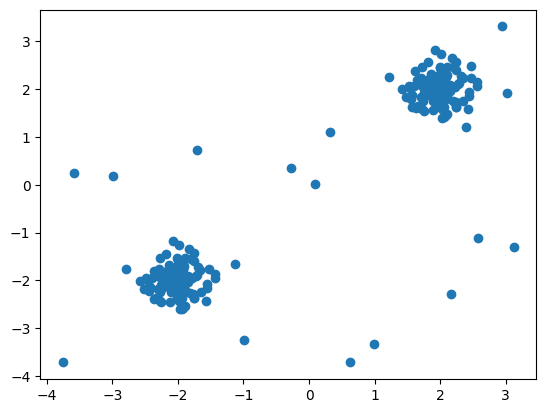

In [16]:
#Ambos, inliers y outliers
X.shape
plt.scatter(X[:,0],X[:,1])
plt.show()

In [17]:
# Creamos un narray indicando si es la observación es atípica (-1) o no (1)
n_outliers = len(X_outliers)
ground_truth = np.ones(len(X), dtype=int)
ground_truth[-n_outliers:] = -1

In [19]:
# Instanciamos y entrenamos LOF (default) y obtenemos y_pred = 1:inlier -1:outlier
clf = LocalOutlierFactor(n_neighbors=10, contamination=0.1)
y_pred = clf.fit_predict(X)

In [20]:
# Cuantificamos los errores
n_errors = (y_pred != ground_truth).sum()
print(n_errors)

8


In [21]:
# Obtenemos los scores
X_scores = clf.negative_outlier_factor_
X_scores

array([-1.00267136, -1.07805602, -0.9512673 , -1.19852585, -0.98858143,
       -1.00679282, -1.14828311, -1.15429128, -0.98890578, -1.18163793,
       -1.23110995, -1.08752515, -0.98492863, -1.01332679, -0.99420565,
       -1.38271848, -1.00743122, -1.11914462, -1.1720002 , -1.02801358,
       -1.06879666, -0.96070001, -1.13630201, -1.0297303 , -1.08392734,
       -0.97182598, -0.99310246, -1.16322193, -0.98815337, -1.03803111,
       -0.98040897, -1.12301987, -1.09479699, -1.02464968, -1.00497631,
       -1.07848009, -1.06753786, -2.25155135, -0.99872498, -1.17288898,
       -0.96349404, -1.26303299, -0.96320264, -1.16023195, -0.97890855,
       -1.01308263, -0.9899821 , -1.10806383, -1.01328984, -0.98878739,
       -1.12636651, -1.01832233, -0.96322332, -1.27223801, -0.98405288,
       -1.29045685, -1.33804792, -0.95782531, -1.02468787, -1.19601131,
       -1.1055269 , -1.23306867, -1.22108962, -1.03568337, -0.98526521,
       -1.11689856, -0.989606  , -1.4017194 , -0.9859617 , -1.11

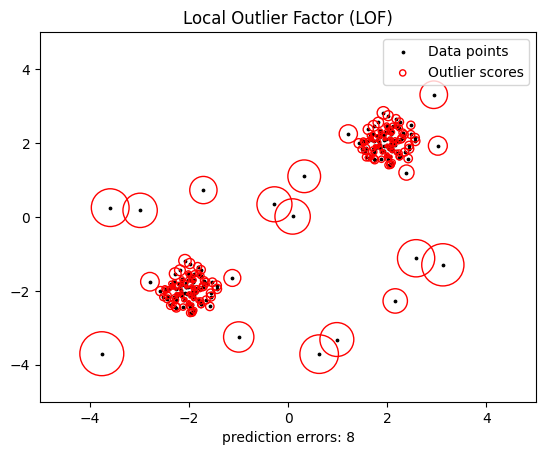

In [22]:
def update_legend_marker_size(handle, orig):
    "Customize size of the legend marker"
    handle.update_from(orig)
    handle.set_sizes([20])


plt.scatter(X[:, 0], X[:, 1], color="k", s=3.0, label="Data points")
# Graficamos circulos con radio proporcional a los outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
scatter = plt.scatter(
    X[:, 0],
    X[:, 1],
    s=1000 * radius,
    edgecolors="r",
    facecolors="none",
    label="Outlier scores",
)
plt.axis("tight")
plt.xlim((-5, 5))
plt.ylim((-5, 5))
plt.xlabel("prediction errors: %d" % (n_errors))
plt.legend(
    handler_map={scatter: HandlerPathCollection(update_func=update_legend_marker_size)}
)
plt.title("Local Outlier Factor (LOF)")
plt.show()

### Detección de atípicos basada en algoritmos de clustering

Se deja como ejercicio